In [1]:
import nglview as ng 
import mdtraj 
import numpy as np 
import os 
from workshop_2_utils import *
os.makedirs("sdf_inputs", exist_ok=True)
os.makedirs("smina_inputs", exist_ok=True)



In [3]:
traj = mdtraj.load("data/6vhn.pdb")

def get_protein_ligand_idxs(traj ,resname=None):
    protein = traj.top.select("protein")
    resname = "not protein and not water" if not resname else resname
    ligand = traj.top.select(resname)
    return protein, ligand

def save_trimmed_pdb(path, traj, idxs):
    traj.atom_slice(idxs).save_pdb(path)


receptor, ligand = get_protein_ligand_idxs(traj)

save_trimmed_pdb("data/ligand.pdb", traj,ligand)
#save_trimmed_pdb("data/receptor.pdb", traj,receptor)



In [4]:
def read_pdb_with_ob(file):
    """Read a molecule file with open babel

    Args:
        infile (Union[str os.PathLike]): input file

    Returns:
        mols (list): list of molecules found in the input file
    """

    try:
        from openbabel import pybel
    except ImportError:
        raise ImportError("Pybel is required for reading openbabel molecules")
    mols = [m for m in pybel.readfile(format="pdb",filename=file)]
    return mols 

def prepare_ob_mols(ligand, outpath, overwrite=False):
    from openbabel import pybel
    out = pybel.Outputfile(format="pdbqt" , filename=outpath,  overwrite=overwrite)
    ligand.addh()
    if not ligand.OBMol.HasNonZeroCoords():
        ligand.make3D()
    ligand.calccharges(model="gasteiger")
    out.write(ligand)
    out.close()
    
ligand_mol= read_pdb_with_ob("data/ligand.pdb")


*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this se

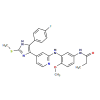

In [5]:
ligand_mol[0]

In [6]:
prepare_ob_mols(ligand_mol[0], "smina_inputs/ligand.pdbqt", overwrite=True)

In [7]:
prep=Preprocessor()
prep.prepare_receptor("data/6vhn_prepared.pdb", "smina_inputs/receptor.pdbqt")
#prep.prepare_ligand("data/ligand.pdb", "smina_inputs/ligand.pdbqt", in_format="pdb")

In [ ]:
# Binding box creations

In [2]:
ligand=mdtraj.load("data/ligand.pdb")
def create_box_from_ligand(ligand):
    xyz=ligand.xyz[0]*10 # convert to Angstrom from nm
    pocket_center = (xyz.max(axis=0) + xyz.min(axis=0)) / 2
    pocket_size = xyz.max(axis=0) - xyz.min(axis=0) + 5
    return Box.from_array(pocket_center, pocket_size)

box=create_box_from_ligand(ligand)
box

Box(center=Point(x=-51.568, y=0.7765, z=23.5065), size=Point(x=11.748001, y=12.989, z=17.699))

In [3]:
from workshop_2_utils import Docking 
    
docker=Docking("smina_inputs/receptor.pdbqt", box) 
        

In [7]:
text=docker.dock_one("smina_inputs/ligand.pdbqt", "outputs/ligand_out.sdf")
docker.parse_output(text)

,affinity,rmsd_lb,rmsd_ub
0,-9.6,0.000,0.000
1,-9.4,1.412,1.651
2,-8.9,2.994,5.769
3,-8.7,3.339,5.062
4,-8.7,3.412,7.919
5,-8.6,3.157,6.173
6,-8.4,1.770,3.398
7,-8.3,3.431,6.015
8,-8.2,3.684,6.214
9,-8.0,2.208,5.329


In [8]:

poses=dm.read_sdf("outputs/ligand_out.sdf", as_df=True, mol_column="mols", n_jobs=-1)
poses

,smiles,mols,minimizedAffinity
0,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297e420>,-9.587195
1,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297e2d0>,-9.425683
2,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297e5e0>,-8.932937
3,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297ec00>,-8.667946
4,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297ec70>,-8.665990
5,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297ece0>,-8.636576
6,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297edc0>,-8.382126
7,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297ed50>,-8.344575
8,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297eff0>,-8.247147
9,CCC(=O)Nc1ccc(OC)c(Nc2cc(-c3nc(SC)[nH]c3-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7f1f4297cba0>,-7.997843


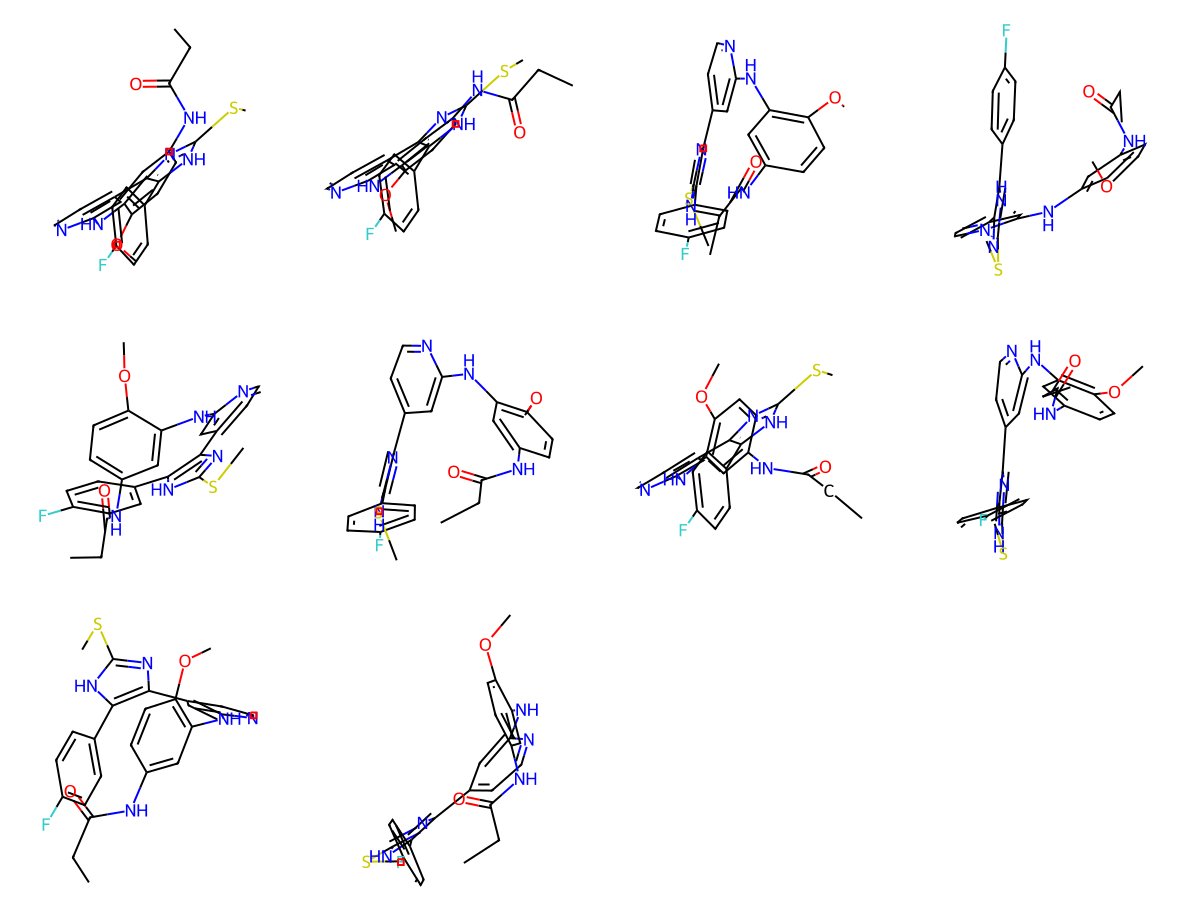

In [10]:
dm.viz.to_image(poses["mols"])

In [ ]:
# Now for some real molecules 

In [5]:
import datamol as dm 
df_mols = dm.read_sdf("/home/cristian/projects/summerschool/data/Enamine_Hinge_Binders_Library_plated_24000cmds_20210316 (1).sdf", as_df=True, mol_column="mols", n_jobs=-1)
docker.parse_mol_to_pbdqt(df_mols["mols"][0])



In [9]:
os.makedirs(outputs, exist_ok=True)
text=docker.dock_one("smina_inputs/mol_0.pdbqt", "outputs/poses_0.sdf")
docker.parse_output(text)
poses=dm.read_sdf("outputs/poses_0.sdf", as_df=True, mol_column="mols", n_jobs=-1)
poses

,smiles,mols,minimizedAffinity
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017cc10>,-5.999578
1,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d380>,-5.913692
2,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d310>,-5.713466
3,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d3f0>,-5.612660
4,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d460>,-5.570094
5,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d4d0>,-5.511775
6,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d540>,-5.422758
7,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d5b0>,-5.372883
8,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d620>,-5.220046
9,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e6017d690>,-5.028538


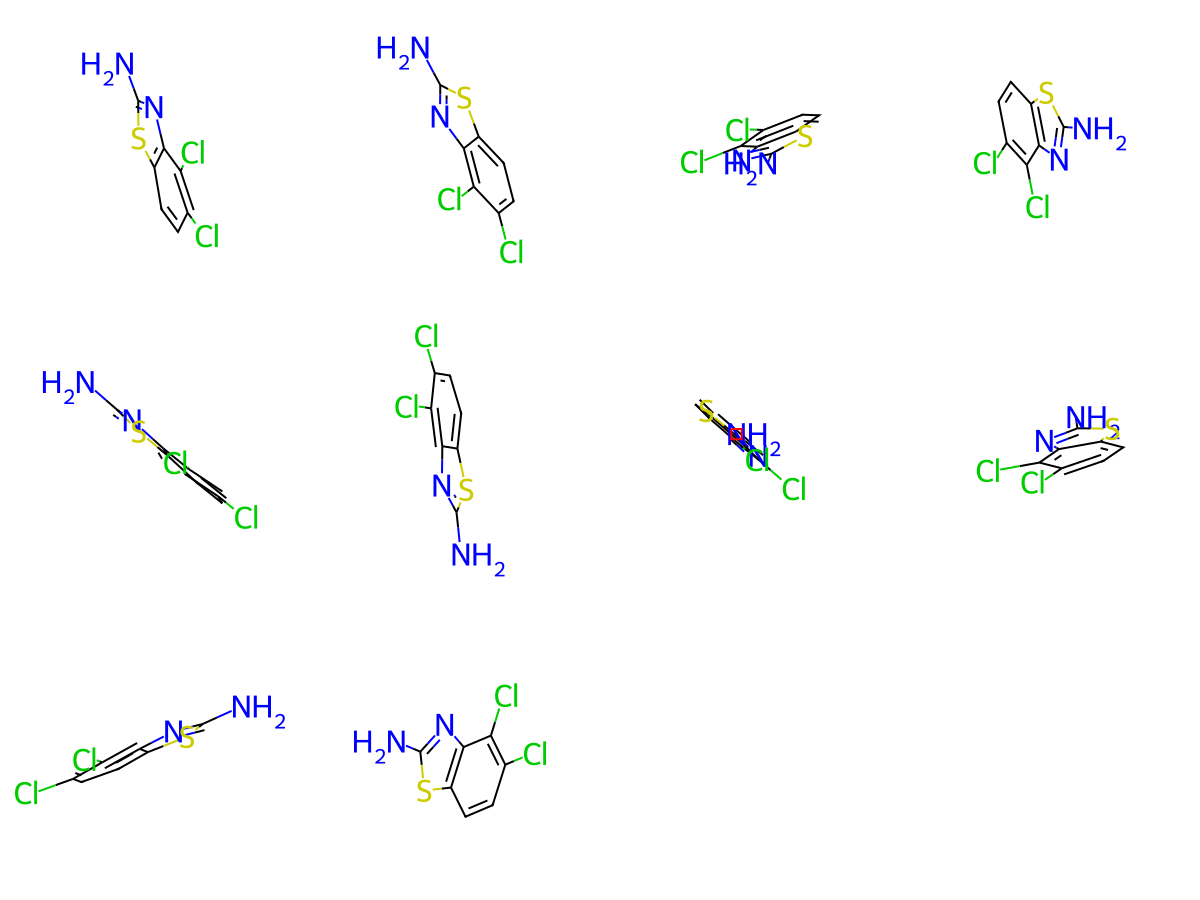

In [10]:
dm.viz.to_image(poses["mols"])

In [13]:
df_mols.head()

,smiles,mols,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9eef96dbd0>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7f9eef96eab0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9eef96ea40>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7f9eef96ec70>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x7f9eef96f290>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3


In [ ]:
df_mols["fp"]=df_mols["mols"].apply(lambda x : dm.to_fp(x))
df_mols

In [38]:
docker=Docking("smina_inputs/receptor.pdbqt", box) 

In [39]:
docker.dock_multiple_mols(
        df_mols["mols"].tolist()[:5], list(range(5))
)      



2024-06-07 18:52:05.895 | INFO     | __main__:dock_multiple_mols:267 - Converting mols to pdbqt in 'smina_inputs' folder
2024-06-07 18:52:05.903 | INFO     | __main__:dock_multiple_mols:271 - Docking
100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
2024-06-07 18:52:12.329 | INFO     | __main__:dock_multiple_mols:276 - Merge all the generated poses together to smina_outputs


In [42]:
poses= dm.read_sdf("smina_outputs/poses.sdf", as_df=True, mol_column="mols", n_jobs=-1)
poses.sort_values("minimizedAffinity",inplace=True)
poses

,smiles,mols,minimizedAffinity
27,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f725cb0>,-6.266315
0,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f725070>,-6.159241
1,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f725000>,-6.155531
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f7251c0>,-6.069037
10,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f725540>,-5.993315
3,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f725230>,-5.972716
11,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f7255b0>,-5.914800
28,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f725d20>,-5.864196
12,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f725620>,-5.736939
13,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7f9e3f725690>,-5.713621


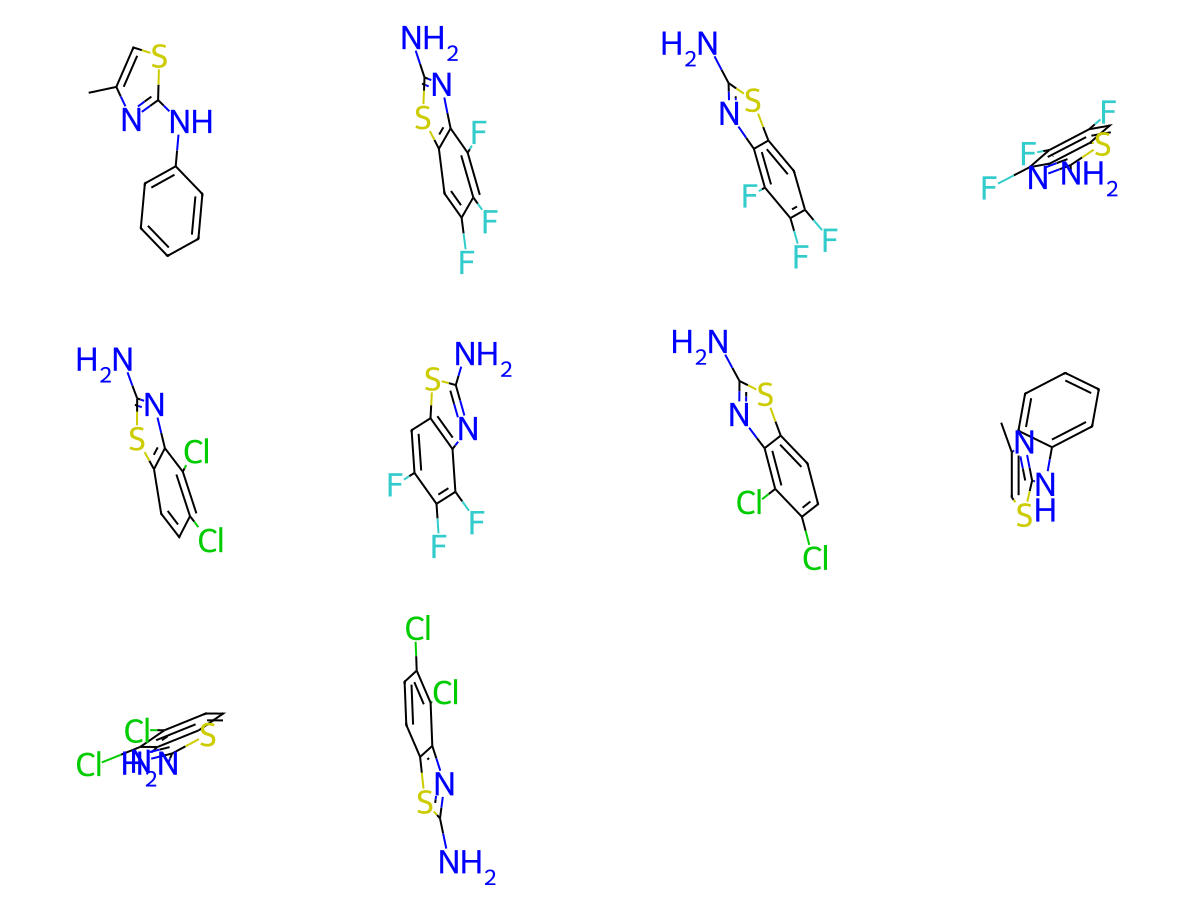

In [44]:
dm.viz.to_image(poses["mols"].tolist()[:10])

In [ ]:
def get_random_idxs(df, n=10, seed=42):
    np.random.seed(seed)
    return np.random.randint(0, len(df), n)


df = init_df_fields(df_mols)
df.head()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

def train_gp(df) -> GaussianProcessRegressor:
    from sklearn.gaussian_process.kernels import RBF
    X = np.vstack(df["fp"][df["sampled"]>=1].tolist())
    Y = np.vstack(df["true_affinity"][df["sampled"]>=1].tolist())
    return GaussianProcessRegressor(kernel=RBF(length_scale=2.0,
                                               length_scale_bounds=(1e-1, 20.0)),
                                     random_state=0).fit(X,Y)

def predict_with_gp(df, gp):
    X = np.vstack(df["fp"].tolist())
    Y = np.vstack(df["true_affinity"].tolist())
    mean, std = gp.predict(X, return_std=True)
    df["pred_affinity"] = mean
    df["uncertainty"] = std
    return df

def samples_next(df, n: int = 10, sort_by_uncertainty = True) -> List[int]:
    original_df = df
    if sort_by_uncertainty:
        ascending=False
        name="uncertainty"
    else:
        ascending=True
        name="pred_affinity"
    return df.sort_values(name, ascending=ascending)["idxs"].tolist()[:n]



#gp=train_gp(df_mols_al)
#df = predict_with_gp(df, gp)
#df.head()

In [ ]:
def get_results(output_dir, idxs):
    values=[]
    key="minimizedAffinity"
    for idx in idxs:
        poses= dm.read_sdf(os.path.join(output_dir, f"poses_{idx}.sdf"), as_df=True, mol_column="mols", n_jobs=-1, sanitize=False)
        poses=poses.sort_values("minimizedAffinity",inplace=False)
        values.append(poses["minimizedAffinity"][0])
    return values

def format_df(df, affinities, sampled_idxs, iteration):
    df["true_affinity"][sampled_idxs]=affinities
    df["sampled"][sampled_idxs]=iteration
    return df

In [ ]:
from copy import deepcopy

N_OF_AL_ITERATIONS = 5
AL_ON_UNCERTAINTY = True
FIRST_LOOP=True # get random idxs at the first loop
N_OF_ORACLE_CALLS=3 # n of samples for initialization
SEED = 42

docker=Docking("smina_inputs/receptor.pdbqt", box, num_poses=3)

ultimate_df = deepcopy(df)
for iteration in range(N_OF_AL_ITERATIONS):
    if FIRST_LOOP:
        FIRST_LOOP = not FIRST_LOOP
        sampled_idxs= get_random_idxs(ultimate_df, n=N_OF_ORACLE_CALLS, seed=SEED).tolist()

    # Create iteration directory
    output_dir = f"al_loop_{iteration}"
    os.makedirs(output_dir,exist_ok=True)

    # Select molecules to dock and dock them
    # really slow on colab
    mols_to_dock=ultimate_df["mols"].to_numpy()[sampled_idxs]
    docker.dock_multiple_mols(mols_to_dock, sampled_idxs, output_dir)

    # Get results
    affinities = get_results(output_dir, sampled_idxs)
    ultimate_df = format_df(ultimate_df, affinities, sampled_idxs, iteration + 1)

    # AL call
    GP = train_gp(ultimate_df)
    ultimate_df = predict_with_gp(ultimate_df, GP)
    sampled_idxs = samples_next(ultimate_df, N_OF_ORACLE_CALLS, AL_ON_UNCERTAINTY)


